In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.2-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.2-bin-hadoop3.tgz
!pip install findspark

--2023-02-19 07:49:48--  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘./spark-3.3.2-bin-hadoop3.tgz’

./spark-3.3.2-bin-h 100%[===================>] 285.49M   154MB/s    in 1.9s    

2023-02-19 07:49:50 (154 MB/s) - ‘./spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

spark-3.3.2-bin-hadoop3/
spark-3.3.2-bin-hadoop3/LICENSE
spark-3.3.2-bin-hadoop3/NOTICE
spark-3.3.2-bin-hadoop3/R/
spark-3.3.2-bin-hadoop3/R/lib/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.2-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3

In [2]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

In [3]:
import os
import numpy as np
import pandas as pd
from scipy import stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import findspark
import random
findspark.init()

In [5]:
findspark.find()

'/content/spark-3.3.2-bin-hadoop3'

In [6]:
import numpy as np
import pyspark
from pyspark.rdd import RDD
from pyspark import SparkContext

In [15]:
sc = pyspark.SparkContext("local", appName="HW2")
spark = SparkSession.builder.master("local[*]").getOrCreate()
# sc = SparkContext.getOrCreate()

In [163]:
sc.stop()

In [16]:
from pyspark.sql import SparkSession
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark

In [17]:
from pyspark.sql.functions import * 
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.sql.functions import substring, length, col, expr,create_map, lit, to_date, create_map, sequence, explode
from itertools import chain
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from pyspark.sql import SQLContext as sqlContext
from itertools import chain
from pyspark.sql.functions import col, row_number
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from matplotlib.dates import MonthLocator, DateFormatter
from pyspark.ml.stat import Correlation

#Functions

In [140]:
class Dictionary:
  '''Takes dictionary type and convert to spark dataframe'''

  def __init__(self, dictionary, col1, col2):
    """initialize dictionary params
    Parameters:
    dictionary: key-value dictionary
    col1: name of column to key
    col2: name of column to value """

    self.dictionary = dictionary
    self.col1 = col1
    self.col2 = col2

  def to_table(self):
    '''Convert dictionary to spark 2 columns dataframe: by assignin the dioctionary keys to the dataframes indexes and the dictionary values to be dataframe cols'''
    for k, v in self.dictionary.items():
      self.dictionary[k] = float(v)   
    table= list(map(list, self.dictionary.items()))
    table_df= spark.createDataFrame(table, [self.col1, self.col2])
    
    return (table_df)

In [141]:
def calc_corr(df, input_feature_names, max_shift):
  """Given dataframe containing timeseries information- this function takes 2 columns of 2 featuure columns and a range of (0, maximum shift)
   and calculates pearson and spearman correlation for every shift in the range and returns 2 dictionaries mapping between the shifts and their respective correlation coeffiecient.

  Parameters:
  df: dataframe 
  input_feature_names: 2 column names (first col is the shifted one) 
  max_shift: maximum number of shifts 

  Return:
  pearson_corrs_dict spearman_corrs_dict: the correlation dictionaries"""
  
  non_shifted_df = df

  pearson_corrs_dict={}
  spearman_corrs_dict={}
  kendall_corrs_dict={}
  
  for shift in range(0, max_shift):
    if (shift==0):
      cancelled_events_ds_shifted = non_shifted_df
    else:
      cancelled_events_ds_shifted = non_shifted_df.withColumn(f"{input_feature_names[0]}",F.lag(F.col(f"{input_feature_names[0]}"),shift).over(Window.partitionBy().orderBy("Date"))).fillna(0)
    
    assembler = VectorAssembler(inputCols= input_feature_names, 
                outputCol="features",handleInvalid='keep')
    
    df = assembler.transform(cancelled_events_ds_shifted).select("features")

    pearson_corr = Correlation.corr(df,"features","pearson").collect()[0][0]
    spearman_corr = Correlation.corr(df,"features","spearman").collect()[0][0]
   
    pearson_corrs_dict[shift]= pearson_corr[0,1]
    spearman_corrs_dict[shift]= spearman_corr[0,1]
    
  return (pearson_corrs_dict, spearman_corrs_dict)

In [142]:
def find_intersection_countries(df1, df2):
  """given two dataframes: df1, df2, this function returns a list of countries whose names appear in both dataframes

  Parameters:
  df1, df2: two dataframe with country column

  Returns:
  intersection_countries: list of countries that appear in both dataframes """

  country_list_df1= df1.select("Country").distinct().rdd.flatMap(lambda x: x).collect()
  country_list_df2= df2.select("Country").distinct().rdd.flatMap(lambda x: x).collect()

  intersection_countries = [value for value in country_list_df1 if value in country_list_df2]
  return (intersection_countries)

In [143]:
class FeatureRelationshipVisualization:
  '''Class for plotting features for generating changes in feature values w.r.t time plots for two given features'''

  def __init__(self, pd, title, scale):
    self.title = title
    self.pd = pd
    self.scale= scale

  def plot_overtime_graph(self, metrics, log):
    '''plot the two given features over time'''

    fig, ax = plt.subplots(figsize=(10, 6))
    x= pd.to_datetime(self.pd['Date'])
    ax.plot(x, self.pd[metrics[0]],label=f'{metrics[0]}')
    ax.plot(x, self.pd[metrics[1]]/self.scale,label=f'{metrics[1]}')
    plt.legend()
    plt.title(f"{self.title}")
    plt.xlabel('Date')
    if (log==True):
      plt.yscale('log')
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.show()
  

In [144]:
class Transform:
  '''Conduct training set and validation set for training the model'''

  def __init__(self, df, label_metric):
    self.df = df
    self.label_metric = label_metric
  
  def assign_quartilies_labels_to_df(self):
    '''Creates columns of quartiles for the dataframe and split the dataframe to buckets based on the label value'''
  
    quartilies_label_assigned_df= (self.df.withColumn("label",F.col(f'{self.label_metric}'))
                                .withColumn('25%', F.expr('percentile(label, 0.25)').over(Window.partitionBy()))
                                .withColumn('50%', F.expr('percentile(label, 0.5)').over(Window.partitionBy()))
                                .withColumn('75%', F.expr('percentile(label, 0.75)').over(Window.partitionBy()))
                                .withColumn("bucket",F.when(F.col("label")<F.col("25%"),1).when(F.col("label")<F.col("50%"),2)
                                .when(F.col("label")<F.col("75%"),3).otherwise(4))
                                )   
    return (quartilies_label_assigned_df) 

  def split_train_test(self, quartilies_labels_df):
    """Split the given dataframe to 20% random samples as test and 80% as train

    Parameters:
    quartilies_labels_df: dataframe that has already been divided to buckets according to label value

    Returns:
    test_df, train_df: test and train dataframes that include 20% and 80% respectively """
     
    bucket_1= (quartilies_labels_df.filter("bucket==1"))
    test_df=bucket_1.sample(False, 0.2)

    for i in range(2,5):
      bucket= (quartilies_labels_df.filter(f"bucket=={i}"))
      test_df= test_df.unionByName(bucket.sample(False, 0.2))
    
    train_df= quartilies_labels_df.join(test_df, on='Date', how='leftanti').drop("25%","50%","75%","bucket",self.label_metric)
    test_df= test_df.drop("25%","50%","75%","bucket",self.label_metric)
  
    return (test_df, train_df)

In [145]:
class Model_metrics:
  '''Class that calculate accuracy metrics for model predictions results'''

  def __init__(self, pred_results, shift_delay):
    self.pred_results = pred_results
    self.shift_delay = shift_delay
    # self.feature_cols = feature_cols
  
  def calc_metrics(self):
    '''Calculate rmse, mar and r^2 for test predictions results and return list of metrics values'''

    rmse=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse=rmse.evaluate(self.pred_results) 

    mae=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
    mae=mae.evaluate(self.pred_results)
    
    r2=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
    r2=r2.evaluate(self.pred_results)

    return([rmse,mae,r2])
    
  def visualize(self, title):
    """gets predictions results and title and create overtime plot of predicted and original label value

    Parameters:
    title: title of the plot

    Returns:
    print plot of predicted and original label value"""
    
    x_ax = range(0, self.pred_results.count())
    y_pred= self.pred_results.select("prediction").collect()
    y_orig= self.pred_results.select("label").collect()

    plt.plot(x_ax, y_orig, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title(f"{title}")
    plt.xlabel('Date')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

In [146]:
def linear_regression(feature_cols, df_test, df_train):
  """gets list of features name and test and train dataframes, covert features to vector and create linear regression model: training on train ddataframe and predict on test.

  Parameters:
  feature_cols: list of column names that will be the features' model
  df_test, df_train: test and train dataframe 

  Returns:
  lr_predictions: linear regression predictions results """
  
  vectorAssembler = VectorAssembler(inputCols = feature_cols, outputCol = 'features')
  v_test_df = vectorAssembler.transform(df_test)
  v_test_df = v_test_df.select(['features', 'label'])

  v_train_df = vectorAssembler.transform(df_train)
  v_train_df = v_train_df.select(['features', 'label'])

  lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
  lr_model = lr.fit(v_train_df)

  lr_predictions = lr_model.transform(v_test_df)
  
  return(lr_predictions)

In [147]:
def gbtregressor(feature_cols, df_test, df_train):
  """gets list of features name and test and train dataframes, covert features to vector and create gbt regression model: training on train ddataframe and predict on test.

  Parameters:
  feature_cols: list of column names that will be the features' model
  df_test, df_train: test and train dataframe 

  Returns:
  preds: gbt regression predictions results
  gbtr: gbt regressor model """
  
  vectorAssembler = VectorAssembler(inputCols = feature_cols, outputCol = 'features')
  v_test_df = vectorAssembler.transform(df_test)
  v_test_df = v_test_df.select(['features', 'label'])

  v_train_df = vectorAssembler.transform(df_train)
  v_train_df = v_train_df.select(['features', 'label'])

  gbtr = GBTRegressor(featuresCol='features', labelCol='label', maxIter=10)
  gbtr = gbtr.fit(v_train_df)

  preds = gbtr.transform(v_test_df)

  return(preds, gbtr)

In [148]:
def prepare_data(df, country, feature_cols, shift):
  """Conduct Conduct training set and validation set for training the model with respect to country and shift days

  Parameters:
  df: dataframe that should be prepared for model
  country: given country
  feature_cols: list of column names that will be the model's features
  shift: number of days to shift the data

  Returns:
  test_df,train_df: test and train dataframes that are already splitted
  v_test_df,v_train_df: vectorized test and train dataframes"""

  transformer = Transform(df.filter(F.col("Country")==country).drop("Code")
                          .withColumn("count_queries",F.lag(F.col("count_queries"),shift).over(Window.partitionBy().orderBy("Date"))).fillna(0)
                            , 'cancel_public_events')
  
  to_buckets= transformer.assign_quartilies_labels_to_df()
  test_df, train_df= transformer.split_train_test(to_buckets)

  vectorAssembler = VectorAssembler(inputCols = feature_cols, outputCol = 'features')
  v_test_df = vectorAssembler.transform(test_df)
  v_test_df = v_test_df.select(['features', 'label'])

  v_train_df = vectorAssembler.transform(train_df)
  v_train_df = v_train_df.select(['features', 'label'])

  return(test_df,train_df,v_test_df,v_train_df)

def calc_ww_regressor(v_test_df, ww_gbt_model, shift, country):
  """predicting value for given vectorized test dataframe using the worldwide gbt regressor with number of shift that shows best performance

  Parameters:
  v_test_df: vectorized test dataframe
  ww_gbt_model: worldwide gbt regressor model that has already trained
  shift: number of days to shift the dataframe
  country: country name that own the test dataframe

  Returns:
  [metrics_results[0],metrics_results[1],metrics_results[2]]: list of the resulted metrics: rmse, mae and r^2 """

  ww_preds= ww_gbt_model.transform(v_test_df)
  model_metrics= Model_metrics(ww_preds, shift)
  metrics_results= model_metrics.calc_metrics()
  model_metrics.visualize(f'"{country} WW GBT regressor, {shift} delay, test VS. pred')

  print(f"{country} WW GBT regressor {shift} shift delay: ")
  print(f"RMSE:{metrics_results[0]}, MAE:{metrics_results[1]}, R2:{metrics_results[2]}")

  return([metrics_results[0],metrics_results[1],metrics_results[2]])

def calc_country_regressor(test_df, train_df, shift, feature_cols, country):
  """prepare test and train dataframes and create gbt regressor with number of shift that shows best performance in ww gbt regressoe

  Parameters:
  test_df: test dataframe
  train_df: train dataframe
  shift: number of days to shift the dataframe
  feature_cols: column names that will be the model's features
  country: country name that own the test dataframe

  Returns:
  [metrics_results[0],metrics_results[1],metrics_results[2]]: list of the resulted metrics: rmse, mae and r^2 """

  gbt_country_shift_pred= gbtregressor(feature_cols, test_df, train_df)[0]
  model_metrics= Model_metrics(gbt_country_shift_pred, shift)
  metrics_results= model_metrics.calc_metrics()
  model_metrics.visualize(f'{country} Country regressor, {shift} delay, test VS. pred')

  print(f"{country} Country GBT regressor {shift} shift delay: ")
  print(f"RMSE:{metrics_results[0]}, MAE:{metrics_results[1]}, R2:{metrics_results[2]}")

  return([metrics_results[0],metrics_results[1],metrics_results[2]])

In [149]:
def regressors(df, country, feature_cols, shift, ww_gbt_model):
  """take each country and calculate for it: 1. predictions for test country dataframe using worldwide gbt regressor with shift
  2.predictions for test country dataframe using gbt regressor the trained on the country dataset with shift
  3.predictions for test country dataframe using gbt regressor the trained on the country dataset without shift

  Parameters:
  df: dataframes that includes all countries
  country: the given country 
  feature_cols: column names that will be the model's features
  shift: number of days to shift the dataframe
  ww_gbt_model:  worldwide gbt regressor model that has already trained

  Returns:
 [country_resuls_ww_18s,country_resuls_country_18s,country_resuls_country_0s]: list of lists: each list includes metrics of rmse, mae and r2.
  the lists are by that order: results of using ww regressor with shift, results using country regressor with shift, anf results using country regressor no shift"""

  test_df,train_df,v_test_df,v_train_df =prepare_data(df, country, feature_cols, shift)
  country_resuls_ww_18s= calc_ww_regressor(v_test_df, ww_gbt_model, shift, country)

  country_resuls_country_18s= calc_country_regressor(test_df, train_df, shift, feature_cols, country)

  test_df_0s,train_df_0s,v_test_df_0s,v_train_df_0s =prepare_data(df, country, feature_cols, 0)
  country_resuls_country_0s= calc_country_regressor(test_df_0s, train_df_0s, 0, feature_cols, country)

  return([country_resuls_ww_18s,country_resuls_country_18s,country_resuls_country_0s])

In [ ]:
def create_worldwide(dataset, feature, covid_agg_2020):
  """create world wide dataframe based on all countries and join with worldwide queries dataset

  Parameters:
  dataset: the analyzed dataset 
  feature: the column name of the dataset we wish to find correlation with
  covid_agg_2020: covid queries dataset

  Returns:
  covid_and_dataset_ww: joined dataframe of worldwide from both datasets"""

  covid_agg_2020_ww= covid_agg_2020.groupBy("Date").agg(F.avg("count_queries").alias("avg_queries"))
  dataset_ww= dataset.groupBy("Date").agg(F.avg(f"{feature}").alias(f"avg_{feature}"))

  covid_and_dataset_ww= dataset_ww.join(covid_agg_2020_ww,on=['Date'])

  return (covid_and_dataset_ww)

def create_intersection(dataset, feature, covid_agg_2020):
  """create intersection dcontries dataframe based on countries that apppears in both dataframes

  Parameters:
  dataset: the analyzed dataset 
  feature: the column name of the dataset we wish to find correlation with
  covid_agg_2020: covid queries dataset

  Returns:
  covid_and_dataset_intersec: joined dataframe of intersections countries from both datasets"""

  intersection_countries_covid_and_dataset= find_intersection_countries(covid_agg_2020, dataset)

  dataset_intersec= dataset.filter(F.col("Country").isin(intersection_countries_covid_and_dataset))
  covid_agg_2020_intersec= covid_agg_2020.filter(F.col("Country").isin(intersection_countries_covid_and_dataset))

  covid_and_dataset_intersec= (dataset_intersec.join(covid_agg_2020_intersec,on=['Country','Date'],how='leftouter').fillna(0)
                            .groupBy("Date").agg(F.avg("count_queries").alias("avg_queries"),F.avg(f"{feature}").alias(f"avg_{feature}"))
                            )
  return (covid_and_dataset_intersec)

In [ ]:
def first_plotting(dataset, feature, is_ww):
  """Takes dataset and plot over time graph that show avg queries and the analyzed feature
  Parameters:
  dataset: covid queries and the analyzed dataset joined
  feature: the column name of the dataset we wish to find correlation with
  is_ww: if the dataset is world wide or intersection"""
  
  if(is_ww==True):
    to_title='worldwide'
  else:
    to_title='intersection countries'

  dataset_pd= dataset.orderBy("Date").toPandas()

  pd_visualize= FeatureRelationshipVisualization(dataset_pd
                          ,f"Average Amount of {feature} VS. Averge Volume of Covid-19-related Search Query Volume in {to_title}"
                          , 100)
  pd_visualize.plot_overtime_graph([f"avg_{feature}",'avg_queries'],log=False)
  print("")

  pd_visualize= FeatureRelationshipVisualization(dataset_pd
                        ,f"(LOG) Average Amount of Covid-19-related Search Query Volume in {to_title} VS. Average Amount of {feature}"
                        , 1)
  pd_visualize.plot_overtime_graph([f"avg_{feature}",'avg_queries'],log=True)


def correlations(dataset, feature, is_ww, max):
  
  pearson_dict, spearman_dict =calc_corr(dataset, ['avg_queries',f"avg_{feature}"], 30)
  pearson_table = Dictionary(pearson_dict, 'shift_delay','pearson').to_table()
  spearman_table = Dictionary(spearman_dict, 'shift_delay','spearman').to_table()

  if(max==True):
    corr_table= (pearson_table.join(spearman_table, on=['shift_delay']).orderBy(F.col('shift_delay').desc())
              .withColumn("max_pearson",F.max("pearson").over(Window.partitionBy()))
              .withColumn("max_spearman",F.max("spearman").over(Window.partitionBy()))
              .filter((F.col("pearson")==F.col("max_pearson"))|(F.col("spearman")==F.col("max_spearman"))| (F.col("shift_delay")==0))
              )
    intersection_shift=corr_table.orderBy(F.col("pearson").desc()).limit(1).select("shift_delay").rdd.flatMap(lambda x:x).collect()[0]

  else:
    corr_table= (pearson_table.join(spearman_table, on=['shift_delay']).orderBy(F.col('shift_delay').desc())
              .withColumn("max_pearson",F.min("pearson").over(Window.partitionBy()))
              .withColumn("max_spearman",F.min("spearman").over(Window.partitionBy()))
              .filter((F.col("pearson")==F.col("min_pearson"))|(F.col("spearman")==F.col("min_spearman"))| (F.col("shift_delay")==0))
              )
    intersection_shift=corr_table.orderBy(F.col("pearson").asc()).limit(1).select("shift_delay").rdd.flatMap(lambda x:x).collect()[0]
  display(corr_table)

    
  return(intersection_shift)

def shift_delay_and_regressors(dataset, feature, is_ww, intersection_shift):
  covid_and_dataset_shifted_intersec_pd= (dataset
                                        .withColumn("avg_queries",F.lag(F.col("avg_queries"),max_intersection_shift).over(Window.partitionBy().orderBy("Date"))).fillna(0)
                                        .orderBy("Date").toPandas()
                                        )
  pd_visualize= FeatureRelationshipVisualization(covid_and_dataset_shifted_intersec_pd
                          ,f"Daily Averge Volume of Covid-19-related Search Query Volume in (Intersection Countries) VS. Daily Average Amount of {to_title} (shifted {max_intersection_shift} days backwards)"
                          ,100)
  pd_visualize.plot_overtime_graph([f"avg_{feature}",'avg_queries'],log=False)

  for shift in [0,max_intersection_shift]:
    transformer = Transform(dataset
                            .withColumn("avg_queries",F.lag(F.col("avg_queries"),shift).over(Window.partitionBy().orderBy("Date"))).fillna(0)
                              , f"avg_{feature}")
    
    to_buckets= transformer.assign_quartilies_labels_to_df()
    test_df, train_df= transformer.split_train_test(to_buckets)

    linear_pred= linear_regression(['avg_queries'], test_df, train_df)
    model_metrics= Model_metrics(linear_pred, shift)
    metrics_results= model_metrics.calc_metrics()
    model_metrics.visualize(f'Intersection Linear regression, {shift} delay, test VS. pred')

    print(f"linear regression with {shift} shift delay: ")
    print(f"RMSE:{metrics_results[0]}, MAE:{metrics_results[1]}, R2:{metrics_results[2]}")

    gbt_pred= gbtregressor(['avg_queries'], test_df, train_df)[0]
    model_metrics= Model_metrics(gbt_pred, shift)
    metrics_results= model_metrics.calc_metrics()
    model_metrics.visualize(f'Intersection GBT regression, {shift} delay, test VS. pred')

    print(f"gbt regression with {shift} shift delay: ")
    print(f"RMSE:{metrics_results[0]}, MAE:{metrics_results[1]}, R2:{metrics_results[2]}")


#Read data

##Covid

Since the queries dataset is divided into 24 seperate datasets (dividing the data based on the month of the query issuing and whether the country of origin of the query is in the USA or not) - The following section merges all seperate datasets into one dataset

In [30]:
#Create a dataset of daily amount of Covid-19-related search queries per country

jan_country_df= spark.read.csv('/home/QueriesByCountry_2020-01-01_2020-01-31.tsv', sep=r'\t', header=True)\
                .withColumn("IsImplicitIntent",F.when(F.col("IsImplicitIntent")=='True',1).otherwise(0))
jan_state_df= spark.read.csv('/home/QueriesByState_2020-01-01_2020-01-31.tsv', sep=r'\t', header=True).drop('State')\
              .withColumn("IsImplicitIntent",F.when(F.col("IsImplicitIntent")=='True',1).otherwise(0))

union_jan= jan_country_df.unionByName(jan_state_df).groupBy("Date","Country").agg(F.count("Query").alias("count_queries"))

covid_agg_2020= union_jan
for date in [['02','29'],['03','31'],['04','30'],['05','31'],['06','30'],['07','31'],['08','31'],['09','30'],['10','31'],['11','30'],['12','31']]:
    month=date[0]
    day=date[1]
    country_df= spark.read.csv(f'/home/QueriesByCountry_2020-{month}-01_2020-{month}-{day}.tsv', sep=r'\t', header=True)\
                .withColumn("IsImplicitIntent",F.when(F.col("IsImplicitIntent")=='True',1).otherwise(0))
    state_df= spark.read.csv(f'/home/QueriesByState_2020-{month}-01_2020-{month}-{day}.tsv', sep=r'\t', header=True).drop('State')\
              .withColumn("IsImplicitIntent",F.when(F.col("IsImplicitIntent")=='True',1).otherwise(0))

    union_one_month= country_df.unionByName(state_df).groupBy("Date","Country").agg(F.count("Query").alias("count_queries"))
    covid_agg_2020= covid_agg_2020.unionByName(union_one_month)

##Public events cancellations

In [33]:
#Reading and adjusting the dataset

public_events_closure_dataset = (spark.read.csv('/home/public-events-covid.csv', header=True)
                                      .withColumnRenamed("Entity","Country")
                                      .withColumnRenamed("Day","Date")
                                      .withColumn("cancel_public_events",F.col("cancel_public_events").cast("int"))
                                      .filter("Date<='2020-12-31' and Date>='2020-01-01'")
)

#Hypothesis

We want to examine the relationship between internet search
query volume (SQV) and various indicators of the pandemic’s impact on economic and social activity, in this case- cancellation of public events.

we will apply statistical analysis techniques to identify the strength and direction of the relationships between SQV and these datasets.

#Intersection: Covid queries and analyzed dataset

We can see that there are countries that should be in the intersection of the respective lists of countries of each dataset, but due to spelling difference in both datasets - they weren't considered as the same country. The  follwing section should fix that:

In [34]:
correction_dict = {"Bosnia And Herzegovina" : "Bosnia and Herzegovina", 
                   "Brunei Darussalam" : "Brunei",
                   "Cote D'ivoire" : "Cote d'Ivoire",
                   "Czech Republic" : "Czechia",
                   "Democratic Republic Of The Congo": "Democratic Republic of Congo",
                   "Macau" : "Macao",
                   "Russian Federation" : "Russia",
                   "Slovak Republic": "Slovakia",
                   "Korea (South)": "South Korea",
                   "Timor-Leste": "Timor",
                   "Trinidad And Tobago": "Trinidad and Tobago",
                   "Viet Nam": "Vietnam",
                   "Virgin Islands (U.S.)": "United States Virgin Islands"}
correction_dict_keys= list(correction_dict.keys())
correction_dict_keys

['Bosnia And Herzegovina',
 'Brunei Darussalam',
 "Cote D'ivoire",
 'Czech Republic',
 'Democratic Republic Of The Congo',
 'Macau',
 'Russian Federation',
 'Slovak Republic',
 'Korea (South)',
 'Timor-Leste',
 'Trinidad And Tobago',
 'Viet Nam',
 'Virgin Islands (U.S.)']

In [35]:
mapping_expr = create_map([lit(x) for x in chain(*correction_dict.items())])

covid_agg_2020 = (covid_agg_2020.withColumn("Country", F.when(F.col("Country").isin(correction_dict_keys)
                  ,mapping_expr.getItem(col("Country"))).otherwise(F.col("Country")))
                  )

/content/spark-3.3.2-bin-hadoop3/python/pyspark/sql/column.py:419: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


In [36]:
#create intersection countries list
intersection_countries_covid_and_cancells= find_intersection_countries(covid_agg_2020, public_events_closure_dataset)

filter out non intersection countries, and create joint dataset to show the daily amount of Covid-19-related search queries vs the daily amount of cancellation of public events 

In [37]:
public_events_intersec= public_events_closure_dataset.filter(F.col("Country").isin(intersection_countries_covid_and_cancells))
covid_agg_2020_intersec= covid_agg_2020.filter(F.col("Country").isin(intersection_countries_covid_and_cancells))

In [38]:
#create intersection countries dataset
covid_and_cancels_intersec= (public_events_intersec.join(covid_agg_2020_intersec,on=['Country','Date'],how='leftouter').fillna(0)
                            .groupBy("Date").agg(F.avg("count_queries").alias("avg_queries"),F.avg("cancel_public_events").alias("avg_cancelled_events"))
                            )

Examining how the daily average amount of Covid-19 related search queries is correlated to the average daily amount of public events cancellations throughout 2020

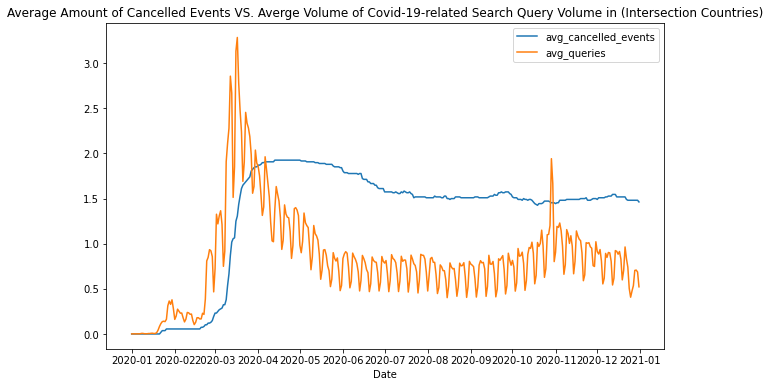

In [39]:
covid_and_cancels_intersec_pd= covid_and_cancels_intersec.orderBy("Date").toPandas()

pd_visualize= FeatureRelationshipVisualization(covid_and_cancels_intersec_pd
                        ,"Average Amount of Cancelled Events VS. Averge Volume of Covid-19-related Search Query Volume in (Intersection Countries)"
                        , 100)
pd_visualize.plot_overtime_graph(['avg_cancelled_events','avg_queries'],log=False)

**Now - we can see that there is a notable delay between fluctuations in search query volume - and their respective 'effect' on the actual number public events cancellations**


Let us find what is the most reasonable delay to take into consideration when expecting to see how search query volume can predict the amount of cancellations of public events:

In [40]:
pearson_dict, spearman_dict =calc_corr(covid_and_cancels_intersec, ['avg_queries','avg_cancelled_events'], 30)
pearson_table = Dictionary(pearson_dict, 'shift_delay','pearson').to_table()
spearman_table = Dictionary(spearman_dict, 'shift_delay','spearman').to_table()

In [41]:
corr_table= (pearson_table.join(spearman_table, on=['shift_delay']).orderBy(F.col('shift_delay').desc())
            .withColumn("max_pearson",F.max("pearson").over(Window.partitionBy()))
            .withColumn("max_spearman",F.max("spearman").over(Window.partitionBy()))
            .filter((F.col("pearson")==F.col("max_pearson"))|(F.col("spearman")==F.col("max_spearman"))| (F.col("shift_delay")==0))
            )
corr_table

shift_delay,pearson,spearman,max_pearson,max_spearman
25,0.7410126902313103,0.7503063404999154,0.7414100229249659,0.7503063404999154
24,0.7414100229249659,0.7501744774679963,0.7414100229249659,0.7503063404999154
0,0.4608494767243805,0.4410020121095953,0.7414100229249659,0.7503063404999154


**Showing the relationship between query volume and events cancellation while taking the (24 days) delay into consideration:**

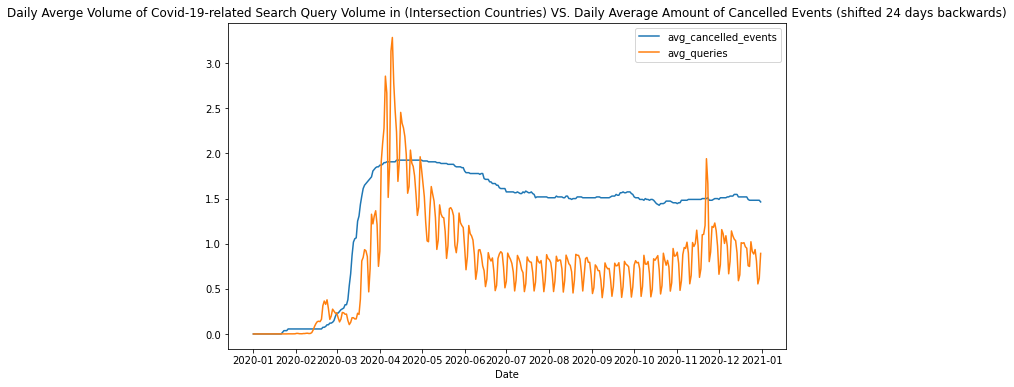

In [42]:
covid_and_cancels_shifted_intersec_pd= (covid_and_cancels_intersec
                                        .withColumn("avg_queries",F.lag(F.col("avg_queries"),24).over(Window.partitionBy().orderBy("Date"))).fillna(0)
                                        .orderBy("Date").toPandas()
                                        )
pd_visualize= FeatureRelationshipVisualization(covid_and_cancels_shifted_intersec_pd
                        ,"Daily Averge Volume of Covid-19-related Search Query Volume in (Intersection Countries) VS. Daily Average Amount of Cancelled Events (shifted 24 days backwards)"
                        ,100)
pd_visualize.plot_overtime_graph(['avg_cancelled_events','avg_queries'],log=False)

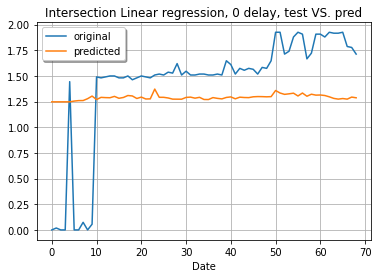

linear regression with 0 shift delay: 
RMSE:0.543996552644383, MAE:0.43771589332618455, R2:-0.022026871221241917


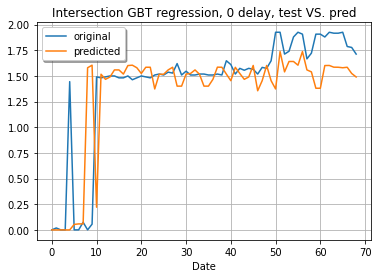

gbt regression with 0 shift delay: 
RMSE:0.23904861610521133, MAE:0.14886884148427884, R2:0.8026475659998581


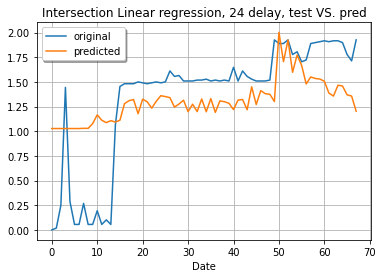

linear regression with 24 shift delay: 
RMSE:0.5123529311469374, MAE:0.4078721524308566, R2:0.38182943359834265


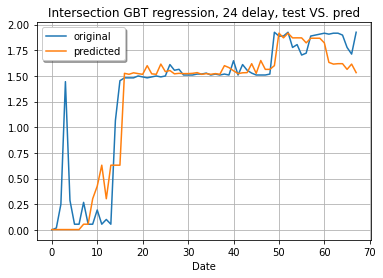

gbt regression with 24 shift delay: 
RMSE:0.14104778200925217, MAE:0.0825475311011022, R2:0.9531507767376864


In [43]:
for shift in [0,24]:
  transformer = Transform(covid_and_cancels_intersec
                          .withColumn("avg_queries",F.lag(F.col("avg_queries"),shift).over(Window.partitionBy().orderBy("Date"))).fillna(0)
                            , 'avg_cancelled_events')
  
  to_buckets= transformer.assign_quartilies_labels_to_df()
  test_df, train_df= transformer.split_train_test(to_buckets)

  linear_pred= linear_regression(['avg_queries'], test_df, train_df)
  model_metrics= Model_metrics(linear_pred, shift)
  metrics_results= model_metrics.calc_metrics()
  model_metrics.visualize(f'Intersection Linear regression, {shift} delay, test VS. pred')

  print(f"linear regression with {shift} shift delay: ")
  print(f"RMSE:{metrics_results[0]}, MAE:{metrics_results[1]}, R2:{metrics_results[2]}")

  gbt_pred= gbtregressor(['avg_queries'], test_df, train_df)[0]
  model_metrics= Model_metrics(gbt_pred, shift)
  metrics_results= model_metrics.calc_metrics()
  model_metrics.visualize(f'Intersection GBT regression, {shift} delay, test VS. pred')

  print(f"gbt regression with {shift} shift delay: ")
  print(f"RMSE:{metrics_results[0]}, MAE:{metrics_results[1]}, R2:{metrics_results[2]}")



**conclusion from above results:**

We see improvement in results for the delay datasets in both linear regression and gbt.
In addition, we see that gbt regressor has better performance that the linear regression in both cases.

**Comparing the Effect of Search Query Volume on Cancellation of Public Events in Countries of interest VS. Worldwid**

Since we've seen that there is a strong relationship between search query volume and the cancellation of public events in the examined countries - we want to extend our scope and make sure that this relationship is not restritced only to those countries. Namely - we are now going to show that taking into consideration search query volume data from **all around the world** and inspecting its effect on the cancellation of public events **all around the world** - suggests that there search query volume fluctuations can be a vlid predictor to the overall **global effect** regarding cancellation of public events:

To start - we first look at the daily search query volume. As mentioned earlier - for certain countries - there are days when no Covid-19 related search query was issued. We can observe that again in the following DataFrame (where the grouping of observations was done by first considering the query's date, and then the query's origin country)

#Worldwide data

(instead of country level data)

Now - since we want to examine the overall **worldwide** relationship between search query volume and cancellation of public events - we want to look at the **daily worldlide average amount of Covid-19-related serach queries and similarly - we want to examine the overall **daily worldwide average of cancellation of public events**

In [49]:
#create the world wide dataset
covid_agg_2020_ww= covid_agg_2020.groupBy("Date").agg(F.avg("count_queries").alias("avg_queries"))
public_events_closure_dataset_ww= public_events_closure_dataset.groupBy("Date").agg(F.avg("cancel_public_events").alias("avg_cancelled_events"))

covid_and_cancels_ww= public_events_closure_dataset_ww.join(covid_agg_2020_ww,on=['Date'])

# covid_and_cancels_ww.show()

+----------+--------------------+------------------+
|      Date|avg_cancelled_events|       avg_queries|
+----------+--------------------+------------------+
|2020-01-05|                 0.0|               5.0|
|2020-01-03|                 0.0|               9.8|
|2020-01-12|                 0.0|               5.1|
|2020-01-22|0.017857142857142856|32.806451612903224|
|2020-01-01|                 0.0|               4.0|
|2020-01-06|                 0.0|              10.0|
|2020-01-16|                 0.0|              8.15|
|2020-01-18|                 0.0| 8.823529411764707|
|2020-01-10|                 0.0| 8.777777777777779|
|2020-01-23| 0.03571428571428571| 34.35042735042735|
|2020-01-28| 0.05357142857142857| 60.71518987341772|
|2020-01-30| 0.05357142857142857| 68.07594936708861|
|2020-01-20|                 0.0|             16.98|
|2020-01-29| 0.05357142857142857|56.707317073170735|
|2020-01-31| 0.05357142857142857| 62.81456953642384|
|2020-01-27| 0.05357142857142857| 57.019108280

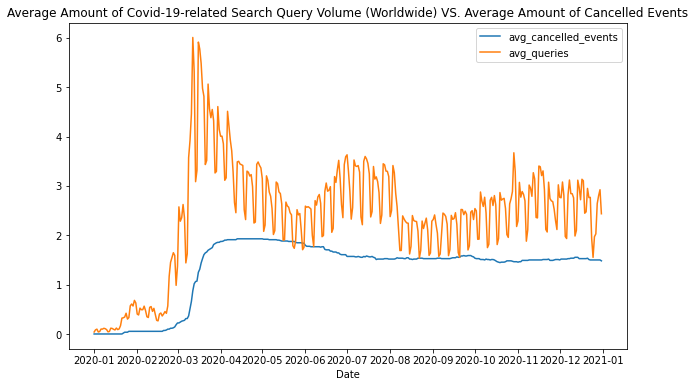

In [50]:
covid_and_cancels_ww_pd= covid_and_cancels_ww.orderBy("Date").toPandas()
pd_visualize= FeatureRelationshipVisualization(covid_and_cancels_ww_pd
                        ,"Average Amount of Covid-19-related Search Query Volume (Worldwide) VS. Average Amount of Cancelled Events"
                        , 100)
pd_visualize.plot_overtime_graph(['avg_cancelled_events','avg_queries'],log=False)

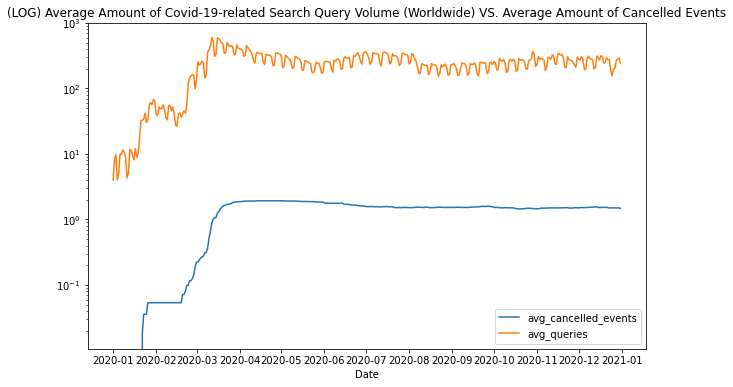

In [51]:
pd_visualize= FeatureRelationshipVisualization(covid_and_cancels_ww_pd
                        ,"(LOG) Average Amount of Covid-19-related Search Query Volume (Worldwide) VS. Average Amount of Cancelled Events"
                        , 1)
pd_visualize.plot_overtime_graph(['avg_cancelled_events','avg_queries'],log=True)

We can see that the **worldwide relationship is actually stronger** than the one we observed earlier (that considers only the 178 countries in the intersection).

Similarly - we would like to find the delay that could best help us predict worldwide cancellation of public events:

In [52]:
pearson_dict, spearman_dict =calc_corr(covid_and_cancels_ww, ['avg_queries','avg_cancelled_events'], 30)
pearson_table = Dictionary(pearson_dict, 'shift_delay','pearson').to_table()
spearman_table = Dictionary(spearman_dict, 'shift_delay','spearman').to_table()

In [53]:
corr_table= (pearson_table.join(spearman_table, on=['shift_delay']).orderBy(F.col('shift_delay').desc())
            .withColumn("max_pearson",F.max("pearson").over(Window.partitionBy()))
            .withColumn("max_spearman",F.max("spearman").over(Window.partitionBy()))
            .filter((F.col("pearson")==F.col("max_pearson"))|(F.col("spearman")==F.col("max_spearman"))| (F.col("shift_delay")==0))
            )
corr_table

shift_delay,pearson,spearman,max_pearson,max_spearman
24,0.8434705899253913,0.6652248335150575,0.8563060503235277,0.6652248335150575
18,0.8563060503235277,0.6635830063528801,0.8563060503235277,0.6652248335150575
0,0.7097828711904077,0.49564804156120745,0.8563060503235277,0.6652248335150575


We see the the strogest correlation is by using 18 days delay

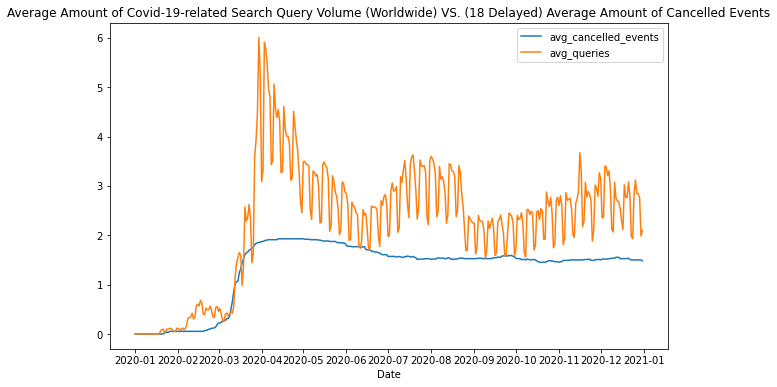

In [54]:
covid_and_cancels_shifted_ww_pd= (covid_and_cancels_ww
                                        .withColumn("avg_queries",F.lag(F.col("avg_queries"),18).over(Window.partitionBy().orderBy("Date"))).fillna(0)
                                        .orderBy("Date").toPandas()
                                        )
pd_visualize= FeatureRelationshipVisualization(covid_and_cancels_shifted_ww_pd
                        ,"Average Amount of Covid-19-related Search Query Volume (Worldwide) VS. (18 Delayed) Average Amount of Cancelled Events"
                        ,100)
pd_visualize.plot_overtime_graph(['avg_cancelled_events','avg_queries'],log=False)

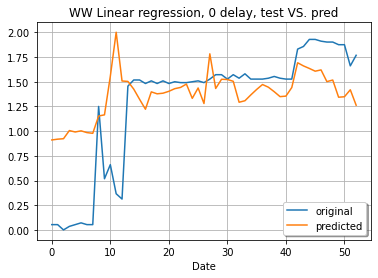

linear regression with 0 shift delay: 
RMSE:0.5041067980785696, MAE:0.36538170234456463, R2:0.3567485060096788


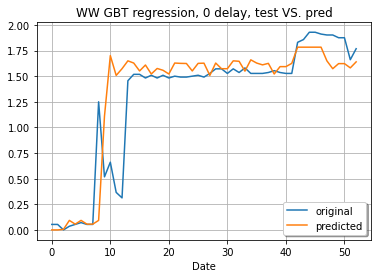

gbt regression with 0 shift delay: 
RMSE:0.2658109949334546, MAE:0.14514483962234653, R2:0.8211530338788815


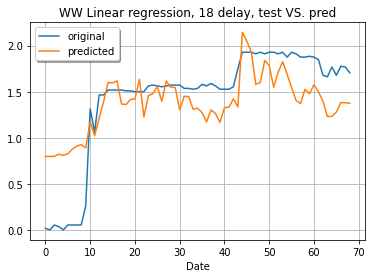

linear regression with 18 shift delay: 
RMSE:0.38961353967317736, MAE:0.3092947395050564, R2:0.5604766552589764


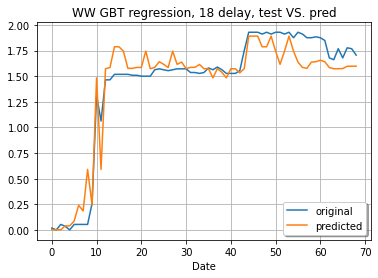

gbt regression with 18 shift delay: 
RMSE:0.18758080152741433, MAE:0.1300161255102961, R2:0.8981196003772253


In [55]:
for shift in [0,18]:
  transformer = Transform(covid_and_cancels_ww
                          .withColumn("avg_queries",F.lag(F.col("avg_queries"),shift).over(Window.partitionBy().orderBy("Date"))).fillna(0)
                            , 'avg_cancelled_events')
  
  to_buckets= transformer.assign_quartilies_labels_to_df()
  test_df, train_df= transformer.split_train_test(to_buckets)

  linear_pred= linear_regression(['avg_queries'], test_df, train_df)
  model_metrics= Model_metrics(linear_pred, shift)
  metrics_results= model_metrics.calc_metrics()
  model_metrics.visualize(f'WW Linear regression, {shift} delay, test VS. pred')

  print(f"linear regression with {shift} shift delay: ")
  print(f"RMSE:{metrics_results[0]}, MAE:{metrics_results[1]}, R2:{metrics_results[2]}")

  gbt_pred= gbtregressor(['avg_queries'], test_df, train_df)[0]
  model_metrics= Model_metrics(gbt_pred, shift)
  metrics_results= model_metrics.calc_metrics()
  model_metrics.visualize(f'WW GBT regression, {shift} delay, test VS. pred')

  print(f"gbt regression with {shift} shift delay: ")
  print(f"RMSE:{metrics_results[0]}, MAE:{metrics_results[1]}, R2:{metrics_results[2]}")



Here again, we see the linear regression has worse results than the gbt regressor in both cases (shifted and non shifted).
Thus, from now we will use only gbt regressor in order to model.

#TEST WW on single country data

We've seen results for aggragated countries data, but now we want to try for single country data.

We will do the following:

1. predict single country data using the world wide gbt with shift of 18

2. train gbt regressor with single country data with shift 18 and predict on its data

3. train gbt regressor with single country data with no shift and predict on its data

In [98]:
transformer = Transform(covid_and_cancels_ww
                          .withColumn("avg_queries",F.lag(F.col("avg_queries"),18).over(Window.partitionBy().orderBy("Date"))).fillna(0)
                            , 'avg_cancelled_events')
  
to_buckets= transformer.assign_quartilies_labels_to_df()
test_df, train_df= transformer.split_train_test(to_buckets)

ww_gbt_model= gbtregressor(['avg_queries'], test_df, train_df)[1]

In [99]:
COUNTRIES= ['France','Germany','United States','United Kingdom','India']

In [100]:
covid_and_cancels_per_country= (public_events_closure_dataset.join(covid_agg_2020,on=['Date','Country'],how='left').fillna(0)
                              .filter(F.col("Country").isin(COUNTRIES))
                              )

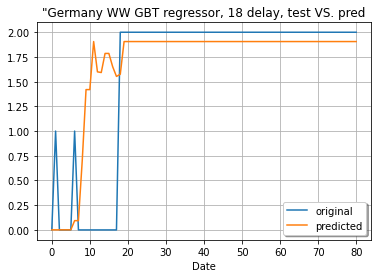

Germany WW GBT regressor 18 shift delay: 
RMSE:0.4782967899216006, MAE:0.23297287178295595, R2:0.6260723313167145


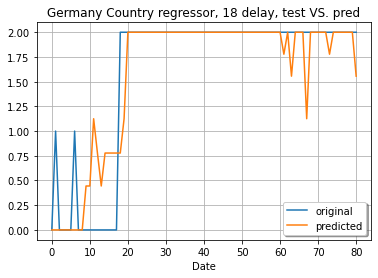

Germany Country GBT regressor 18 shift delay: 
RMSE:0.28835734442815514, MAE:0.11093964334705077, R2:0.8640889698555057


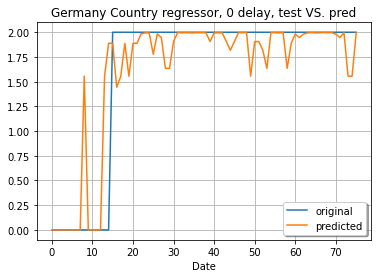

Germany Country GBT regressor 0 shift delay: 
RMSE:0.2712644401578134, MAE:0.1231599560598623, R2:0.8719808812800885


In [135]:
germany_results= regressors(covid_and_cancels_per_country, 'Germany', ['count_queries'], 18, ww_gbt_model)

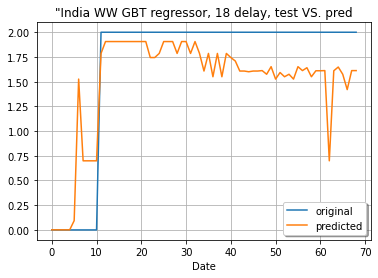

India WW GBT regressor 18 shift delay: 
RMSE:0.39780015114041256, MAE:0.30576091229012936, R2:0.6609341783359306


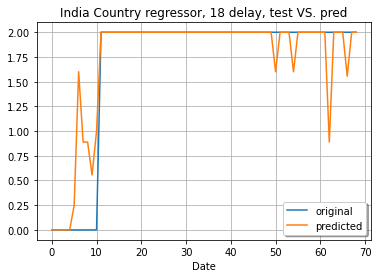

India Country GBT regressor 18 shift delay: 
RMSE:0.29860488515398453, MAE:0.0931561996779388, R2:0.8089496032936627


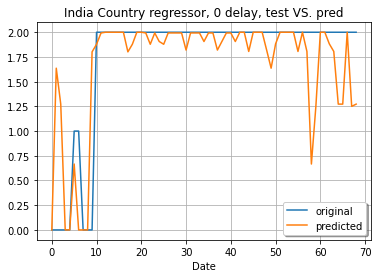

India Country GBT regressor 0 shift delay: 
RMSE:0.4343842222789584, MAE:0.19520564333959364, R2:0.6193426119231069


In [125]:
india_results= regressors(covid_and_cancels_per_country, 'India', ['count_queries'], 18, ww_gbt_model)

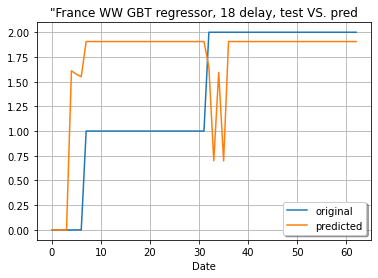

France WW GBT regressor 18 shift delay: 
RMSE:0.7115845311414298, MAE:0.5283747906748879, R2:-0.10545283330325694


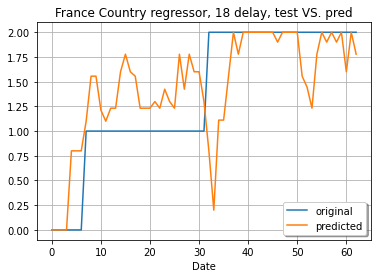

France Country GBT regressor 18 shift delay: 
RMSE:0.48894382892343546, MAE:0.33230114350052914, R2:0.4780785350571356


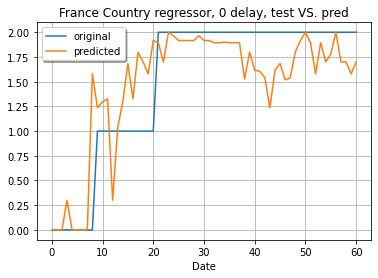

France Country GBT regressor 0 shift delay: 
RMSE:0.3923280570455296, MAE:0.2699545035308081, R2:0.717583247796749


In [130]:
france_results= regressors(covid_and_cancels_per_country, 'France', ['count_queries'], 18, ww_gbt_model)

#Other datasets

**The above flow was for one dataset- the publit cancellation events.
However, using the modr 'general' functions, we can run the same flow on any other dataset**

Same flow for

retail_and_recreation

In [ ]:
#Reading and adjusting the dataset

retailers_dataset = (spark.read.csv('/home/change-visitors-retail-recreation.csv', header=True)
                                      .withColumnRenamed("Entity","Country")
                                      .withColumnRenamed("Day","Date")
                                      .withColumn("retail_and_recreation",F.col("retail_and_recreation").cast("int"))
                                      .filter("Date<='2020-12-31' and Date>='2020-01-01'")
)

In [ ]:
#create intersect dataset with quries data
intersection_dataset=create_intersection(retailers_dataset, 'retail_and_recreation', covid_agg_2020)

In [ ]:
#view by plot the correlation
first_plotting(intersection_dataset, 'retail_and_recreation', is_ww=False)

this dataset has negative correlation with the queries covid dataseet, thus we want to find the most negative pearson/spearman

In [ ]:
min_shift= correlations(intersection_dataset, 'retail_and_recreation', is_ww=False, max=False)

In [ ]:
#apply regressors
shift_delay_and_regressors(intersection_dataset, 'retail_and_recreation', is_ww=False, max_shift)

In [ ]:
#create worldwide dataset
ww_dataset=create_worldwide(retailers_dataset, 'retail_and_recreation', covid_agg_2020)

In [ ]:
#view by plot the correlation
first_plotting(ww_dataset, 'retail_and_recreation', is_ww=True)

In [ ]:
min_shift= correlations(ww_dataset, 'retail_and_recreation', is_ww=True, max=Flase)

In [ ]:
#apply regressors
shift_delay_and_regressors(ww_dataset, 'retail_and_recreation', is_ww=True, min_shift)

In [ ]:
#apply to single country dataset
transformer = Transform(ww_dataset
                          .withColumn("avg_queries",F.lag(F.col("avg_queries"),18).over(Window.partitionBy().orderBy("Date"))).fillna(0)
                            , 'avg_retail_and_recreation')
  
to_buckets= transformer.assign_quartilies_labels_to_df()
test_df, train_df= transformer.split_train_test(to_buckets)

ww_gbt_model= gbtregressor(['avg_queries'], test_df, train_df)[1]

In [ ]:
covid_and_dataset_per_country= (retailers_dataset.join(covid_agg_2020,on=['Date','Country'],how='left').fillna(0)
                               )

In [ ]:
germany_results= regressors(covid_and_dataset_per_country, 'Germany', ['count_queries'], 18, ww_gbt_model)

In [ ]:
india_results= regressors(covid_and_dataset_per_country, 'India', ['count_queries'], 18, ww_gbt_model)

In [ ]:
france_results= regressors(covid_and_dataset_per_country, 'France', ['count_queries'], 18, ww_gbt_model)